In [2]:
# These are all the modules and definitions you will need in this notebook
import batman
from astropy.stats import BoxLeastSquares

import os
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 75
rcParams["figure.dpi"] = 75
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)
logger.propagate = False

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt


#stuff for getting FFI data from MAST
import astropy
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.wcs import WCS
from astropy.io import fits
import astropy.units as u

#in case there are WiFi issues, these may help
from urllib.error import HTTPError
import requests

#stuff for detecting periodic transit events
from transitleastsquares import catalog_info

import time as clock

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


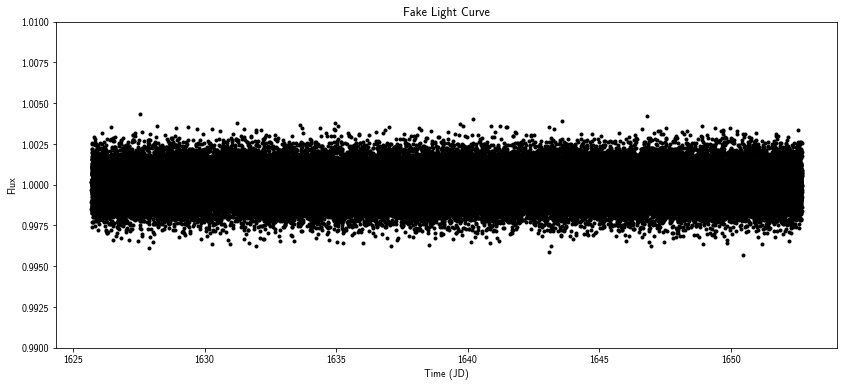

30.00038580743065 minutes


In [3]:
fs=10 #fontsize for text in figures

ndays = 27 #days
cadence= 2*60 #take measurement twice an hour
pts_per_day = 24*cadence #data points per day
scatter_frac = 0.00099+0.000001  # add scatter to data to make it realistic

start=0.0
stop=ndays
stepsize=ndays*pts_per_day
t = 2458625.7 + np.linspace(start, stop, stepsize) -2457000

flux = 1.0 + np.random.randn(t.size) * scatter_frac
fluxerr = np.ones_like(flux) * scatter_frac

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,flux,marker='.',color='black',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Fake Light Curve")
plt.ylim(0.99,1.01)
plt.show()

texp = np.median(np.diff(t)); print(texp*24*60*60, 'minutes')

In [4]:
print(len(t))

77760


Period:  1.4128919662158916
time start:  1626.932307514362
planet radius (RE):  1.526679659939888
Stellar radius (RS):  0.42344149694509003


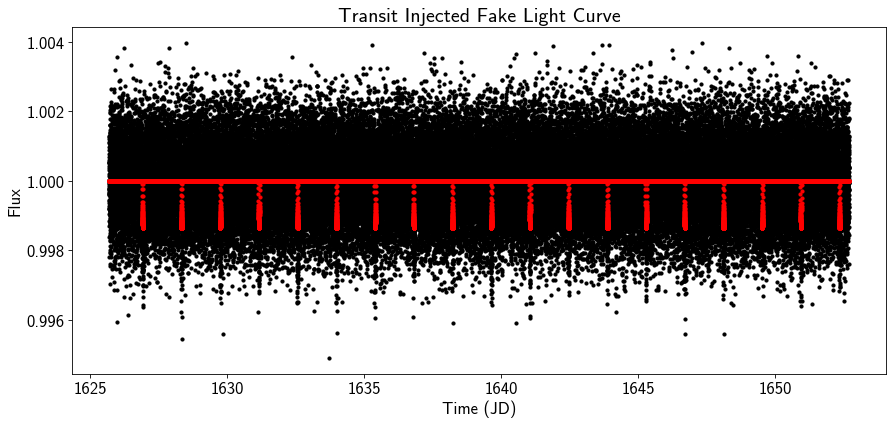

In [121]:
Rad_sun = 6.955*10.0**10.0 #cm
Rad_earth = 6.378*10.0**8.0 #cm
Mass_Sun = 1.989*10.0**33.0 #grams

logg=np.float64(4.8)
logg_err=np.float64(0.003)
R_star=np.float64(0.396*Rad_sun)
R_star=np.float64(np.random.uniform(0.1,0.5)*Rad_sun)
R_star_err=np.float64(0.01)
import random

# TLS_P=np.float64(8.3910)
TLS_P=np.random.uniform(texp,ndays/3.0) #from 30 min to length of LC/3
# TLS_TC=t[46]
TLS_TC=random.choice(t)
time_start =TLS_TC
R_P=1.1
R_P=np.random.uniform(0.5,2) #mars to Super Earth sized


print('Period: ',TLS_P)
print('time start: ',TLS_TC)
print('planet radius (RE): ',R_P)
print('Stellar radius (RS): ',R_star/Rad_sun)

# Use batman to create transits
ma = batman.TransitParams()
ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
ma.per = TLS_P  # orbital period
ma.rp = R_P*Rad_earth/(R_star)  # planet radius (in units of stellar radii) 
ma.a = 10  # semi-major axis (in units of stellar radii)
ma.inc = 90  # orbital inclination (in degrees)
ma.ecc = 0  # eccentricity
ma.w = 90  # longitude of periastron (in degrees)
qld_a=0.4; qld_b=0.4
ma.u = [qld_a, qld_b]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = batman.TransitModel(ma, t,exp_time=texp)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

injectedflux = synthetic_signal- flux+1

plt.figure(figsize=(14,6)) #width, height
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False) #turns off scientific notation
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.plot(t,injectedflux,marker='.',color='black',linestyle='none')
plt.plot(t,synthetic_signal,marker='.',color='red',linestyle='none')
plt.xlabel("Time (JD)")
plt.ylabel("Flux")
plt.title("Transit Injected Fake Light Curve")
# plt.ylim(0.99,1.01)
plt.show()



T0s=[TLS_TC][0]
Periods=[TLS_P][0]
Depths=np.array([(R_P*Rad_earth/R_star)**2])[0] #*1e-3 #ppt to ppm conversion


T = np.ascontiguousarray(t, dtype=np.float64)
F = np.ascontiguousarray((injectedflux - 1.0) * 1e3, dtype=np.float64)
E = np.ascontiguousarray(fluxerr * 1e3, dtype=np.float64)

F = np.ascontiguousarray(injectedflux-1.0, dtype=np.float64)
E = np.ascontiguousarray(fluxerr , dtype=np.float64)

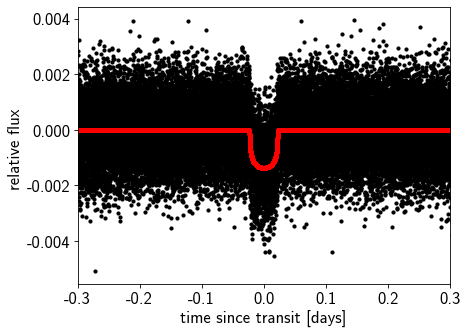

In [122]:
x_fold = (T - T0s + 0.5*Periods) % Periods - 0.5*Periods

# plt.plot(x_fold, F,'k.')
# plt.plot(x_fold,synthetic_signal-1,'b.')
# plt.xlabel("time since transit [days]")
# plt.ylabel("relative flux ");
# plt.show()

plt.plot(x_fold, F,'k.')
plt.plot(x_fold,synthetic_signal-1,'r.')
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux ");
plt.xlim(-0.3,0.3)
plt.show()

x=T
y=F
yerr=E

period_guess=Periods
t0_guess=T0s
r_guess=ma.rp #RP in units of RS

In [120]:
import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)
logger.propagate = False

ID='123456789'
Sector='00'

In [110]:
def build_model3(time, flux, error, periods, t0s, depths, qld_a, qld_b,\
                 logg, logg_err, R_star, R_star_err, ID, Sector, \
                 mask=None, start=None):
    x=time
    y=flux
    yerr=error
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)[0]
    t0s = np.atleast_1d(t0s)[0]
    depths = np.atleast_1d(depths)[0]
    r_guess = np.sqrt(depths) # R_Planet / R_Star
    
    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=0.0, sd=1.0)
        
        logg_star = pm.Normal("logg_star", mu=logg, sd=logg_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=R_star, sd=R_star_err)
        rho_star = pm.Deterministic("rho_star", 10**logg / r_star)
        
        
        
        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0)#, shape=2)

        # The log period; also tracking the period itself
        #Problem?
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1)#, shape=2)
        period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u", testval=np.array([qld_a,qld_b]))

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=r_guess-0.01, max_radius=r_guess+0.01, 
            testval_r=r_guess, testval_b=np.random.uniform(0,1))
        
        r_planet = pm.Deterministic("r_pl", r * R_star)
        
        
        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b,\
                                        r_star=r_star, rho_star=rho_star)

        # Compute the model light curve using starry
        star = xo.StarryLightCurve(u)
        light_curve = star.get_light_curve(orbit=orbit, r=r_planet, t=x, texp=texp)
        
        light_curve = pm.math.sum(light_curve, axis=-1) + mean 
        model.light_curve=light_curve
        # Here we track the value of the model light curve for plotting
        # purposes
        pm.Deterministic("light_curves", light_curve)

        # In this line, we simulate the dataset that we will fit
        y = xo.eval_in_model(light_curve)
        y += yerr * np.random.randn(len(y))
        model.x=x
        model.y=y
        model.yerr=yerr
        
        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        
        # The likelihood function assuming known Gaussian uncertainty
#         pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln

#         model.map_soln = xo.optimize(start=model.test_point)
        
        
    return model    

In [111]:

def build_model_sigma_clip3(ID,Sector,time, flux, error,logg,logg_err,R_star,R_star_err, qld_a,qld_b, periods, t0s, depths, sigma=5.0, maxiter=10):
#     start_time=clock.time()
    x=time
    y=flux
    yerr=error
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
#         print(start)
#         model = build_model2(x,y,yerr, periods, t0s, depths, qld_a,qld_b, ID, Sector, mask=None, start=None)
        model = build_model3(x,y,yerr, periods, t0s, depths, qld_a, qld_b,logg, logg_err, R_star, R_star_err, ID, Sector, mask=None, start=None)


        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()
#     print('runtime: ',(clock.time()-start_time)/60.0," minutes")
    return model

In [112]:
def build_model2(time, flux, error, periods, t0s, depths, qld_a,qld_b, ID, Sector, mask=None, start=None):
    x=time
    y=flux
    yerr=error
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)[0]
    t0s = np.atleast_1d(t0s)[0]
    depths = np.atleast_1d(depths)[0]
    r_guess = np.sqrt(depths) # R_Planet / R_Star
    
    with pm.Model() as model:

        # The baseline flux
        mean = pm.Normal("mean", mu=0.0, sd=1.0)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0)#, shape=2)

        # The log period; also tracking the period itself
        #Problem?
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1)#, shape=2)
        period = pm.Deterministic("period", pm.math.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u", testval=np.array([qld_a,qld_b]))

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=r_guess-0.05, max_radius=r_guess+0.05, 
            testval_r=r_guess, testval_b=np.random.uniform(0,1))

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

        # Compute the model light curve using starry
        star = xo.StarryLightCurve(u)
        light_curve = star.get_light_curve(orbit=orbit, r=r, t=x, texp=texp)
        
        #doesn't work, broadcast issues?
        light_curve = pm.math.sum(light_curve, axis=-1) + mean 
        model.light_curve=light_curve
        # Here we track the value of the model light curve for plotting
        # purposes
        pm.Deterministic("light_curves", light_curve)

        # In this line, we simulate the dataset that we will fit
        y = xo.eval_in_model(light_curve)
        y += yerr * np.random.randn(len(y))
        model.x=x
        model.y=y
        model.yerr=yerr
        # The likelihood function assuming known Gaussian uncertainty
        pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

        # Fit for the maximum a posteriori parameters given the simuated
        # dataset

        model.map_soln = xo.optimize(start=model.test_point)
        
        
    return model

In [113]:

# def build_model_sigma_clip2(time, flux, error,logg,logg_err,R_star,R_star_err, qld_a,qld_b, periods, t0s, depths, sigma=5.0, maxiter=10):
def build_model_sigma_clip2(time, flux, error, qld_a,qld_b, periods, t0s, depths, sigma=5.0, maxiter=10):
#     start_time=clock.time()
    x=time
    y=flux
    yerr=error
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
#         print(start)
        model = build_model2(x,y,yerr, periods, t0s, depths, qld_a,qld_b, ID, Sector, mask=None, start=None)
#         start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()
#     print('runtime: ',(clock.time()-start_time)/60.0," minutes")
    return model

In [90]:
# model = build_model_sigma_clip2(T,F,E, qld_a,qld_b, 
#                                 Periods, T0s, Depths, 
#                                 sigma=5.0, maxiter=10)

# # model = build_model_sigma_clip3(ID,Sector,T,F,E,logg,logg_err,\
# #                                 R_star,R_star_err, qld_a,qld_b, 
# #                                 Periods,T0s, Depths, 
# #                                 sigma=5.0, maxiter=10)

In [91]:

# #if multiple planets input
# letters = "bcdefghijklmnopqrstuvwxyz"[:len([Periods])]
# with model:
#     mean = model.map_soln["mean"]
#     light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)
    
# plt.plot(model.x, model.y - mean, "k.", label="data")
# for n, l in enumerate(letters):
    
# #     print(np.shape(light_curves[:,n]),np.shape(model.x))
    
#     plt.plot(model.x, light_curves, "b.",label="planet {0}".format(l), zorder=100-n)
#     plt.plot(model.x, synthetic_signal-1, 'r.',label="injected model", zorder=99-n)

# plt.xlabel("time [days] TJD")
# plt.ylabel("norm. flux")
# plt.title("initial fit")
# # plt.xlim(model.x.min(), model.x.max())
# plt.legend(fontsize=10);
# plt.show()


# for n, l in enumerate(letters):
    
# #     print(np.shape(light_curves[:,n]),np.shape(model.x))
    
#     plt.plot(model.x, light_curves, 'b.',label="planet {0}".format(l), zorder=100-n)
#     plt.plot(T, synthetic_signal-1, 'r.',label="injected model", zorder=99-n)
# plt.show()

In [92]:
# t0_init=model.map_soln["t0"]
# per_init=model.map_soln["period"]

# x_fold_init = (model.x - t0_init + 0.5*per_init) % per_init - 0.5*per_init
# plt.plot(x_fold_init,model.y-mean,"k.", label="data")
# plt.plot(x_fold_init,light_curves, "b.",label="planet {0}".format(l), zorder=100-n)
# plt.plot(x_fold, synthetic_signal-1, 'r.',label="injected model", zorder=99-n)
# plt.xlim(-0.3,0.3)
# plt.show()

In [93]:
# import time as clock

# start_time=clock.time()

# np.random.seed(123)
# sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
# with model:
#     burnin = sampler.tune(tune=3000, start=model.map_soln,
#                           step_kwargs=dict(target_accept=0.9),
#                           chains=2, cores=2)
#     trace = sampler.sample(draws=1000, chains=2, cores=2)
    
# print('runtime: ',(clock.time()-start_time)/60.0, ' minutes') #minutes

In [94]:
# with model:
# #     light_curves = np.empty((500, len(model.x), len(Periods)))
# #     light_curves = np.empty((500, len(model.x), 2))
#     light_curves = np.empty((500, len(model.x)))#, 1))
    
#     func = xo.utils.get_theano_function_for_var(model.light_curves)
#     for i, sample in enumerate(xo.utils.get_samples_from_trace(
#             trace, size=len(light_curves))):
#         light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

# for n, letter in enumerate(letters):
#     plt.figure()
    
#     # Compute the GP prediction
#     mean_mod = 0#np.median(trace["mean"])#[:, None])

#     # Get the posterior median orbital parameters
#     p = np.median(trace["period"])##[:, n]) #<-too many indices
#     t0 = np.median(trace["t0"])##[:, n])

#     # Compute the median of posterior estimate of the contribution from
#     # the other planet. Then we can remove this from the data to plot
#     # just the planet we care about.
    
#     inds = np.arange(0) != n
# #     inds = np.arange(2) != n
# #     inds = np.arange(1) != n
#     others = np.median(np.sum(light_curves[:, inds], axis=-1), axis=0)
# #     others = np.median(np.sum(light_curves, axis=-1), axis=0)

#     # Plot the folded data
#     x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
#     plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

#     # Plot the folded model
#     inds = np.argsort(x_fold)
#     inds = inds[np.abs(x_fold)[inds] < 0.3]
# #     pred = light_curves[:, inds, n]
#     pred = light_curves[:, inds]#, 0]
#     pred = np.percentile(pred, [16, 50, 84], axis=0)
#     plt.plot(x_fold[inds], pred[1], color="C1", label="model")
#     art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
#                            zorder=1000)
#     art.set_edgecolor("none")

#     # Annotate the plot with the planet's period
# #     txt = "period = {0:.4f} +/- {1:.4f} d ; TC = {2:.4f}".format(
# #         np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]), np.mean(trace["t0"][:, n])-2457000)
# #     plt.annotate(txt, (0, 0), xycoords="axes fraction",
# #                  xytext=(5, 5), textcoords="offset points",
# #                  ha="left", va="bottom", fontsize=12)
#     txt = "period = {0:.4f} +/- {1:.4f} d ; TC = {2:.4f}".format(
#         np.mean(trace["period"]), np.std(trace["period"]), np.mean(trace["t0"])-2457000)
#     plt.annotate(txt, (0, 0), xycoords="axes fraction",
#                  xytext=(5, 5), textcoords="offset points",
#                  ha="left", va="bottom", fontsize=12)

#     plt.legend(fontsize=10, loc='upper center',ncol=2)

#     plt.xlabel("time since transit [Hrs]")
#     plt.ylabel("relative flux")
#     plt.title("TIC {0}-{1} ; Sector {2}".format(ID, letter, Sector));
#     plt.xlim(-0.3,0.3)
#     plt.show()
# print('True Period: ',TLS_P)
# print('True time start: ',TLS_TC)
# print('True planet radius (RE): ',R_P)
# print('True Stellar radius (RS): ',R_star/Rad_sun)    
    
# plt.plot(x_fold[inds], pred[1], "C1")
# art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
#                        zorder=1000)
# art.set_edgecolor("none")

# plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)
# x_fold_synthetic=(T - TLS_TC + 0.5*TLS_P) % TLS_P - 0.5*TLS_P
# plt.plot(x_fold_synthetic,synthetic_signal-1,'r.')    
# plt.xlim(-0.3,0.3)
# plt.ylim(-0.005,0.005)
# plt.show()
    

In [95]:
# pm.summary(trace)

In [36]:
# print(mean)

NameError: name 'mean' is not defined

In [96]:
# # Convert to Earth radii
# r_pl = trace["r"]*R_star/Rad_earth  #rp/sun
# samples = np.concatenate((r_pl, trace["b"]), axis=-1)

# # labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
# # labels += ["impact param {0}".format(i) for i in letters]

# # corner.corner(samples, labels=labels, show_titles=True, title_kwargs=dict(fontsize=10));
# # plt.show()

# labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
# labels += ["$t0_{{{0}}} $ [TBJD]".format(i) for i in letters]
# # labels += ["$R_{{\mathrm{{Pl}},{0}}}$ ".format(i) for i in letters]
# labels += ["$R_{P}/R_{S}$ "]#.format(i) for i in letters]
# labels += ["impact param {0}".format(i) for i in letters]

# n=len(letters)
# samples = pm.trace_to_dataframe(trace, varnames=["period", "t0","r","b"])
# truth = np.concatenate(xo.eval_in_model([tt.as_tensor_variable([TLS_P]), tt.as_tensor_variable([TLS_TC-2457000])], model.test_point, model=model))

# # corner.corner(samples)

# corner.corner(samples,labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs=dict(fontsize=10));

# plt.tight_layout()
# plt.show()

In [123]:
#wrap it all together in one function

MCMCfigpath=os.getcwd()+'/MCMC_figures/'

def MCMC_planet_model(ID, Sector, T,F,E, qld_a, qld_b, R_star, R_star_err, Periods, T0s, Depths, MCMCfigpath):
    
    model = build_model_sigma_clip2(T,F,E, qld_a,qld_b, 
                                Periods, T0s, Depths, 
                                sigma=5.0, maxiter=10)
    
    print('plotting initial guesses')
    print(' ')
    #if multiple planets input
    letters = "bcdefghijklmnopqrstuvwxyz"[:len([Periods])]
    with model:
        mean = model.map_soln["mean"]
        light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

    plt.plot(model.x, model.y - mean, "k.", label="data")
    for n, l in enumerate(letters):

    #     print(np.shape(light_curves[:,n]),np.shape(model.x))

        plt.plot(model.x, light_curves, "b.",label="planet {0}".format(l), zorder=100-n)
        plt.plot(model.x, synthetic_signal-1, 'r.',label="injected model", zorder=99-n)

    plt.xlabel("time [days] TJD")
    plt.ylabel("norm. flux")
    plt.title("initial fit")
    # plt.xlim(model.x.min(), model.x.max())
    plt.legend(fontsize=10,ncol=3);
    plt.savefig(MCMCfigpath+"TIC_"+str(ID)+"_Sector_"+str(Sector)+'_LC_intialguess.png')
    plt.show()
    
    t0_init=model.map_soln["t0"]
    per_init=model.map_soln["period"]
    x_fold = (T - T0s + 0.5*Periods) % Periods - 0.5*Periods
    x_fold_init = (model.x - t0_init + 0.5*per_init) % per_init - 0.5*per_init
    plt.plot(x_fold_init,model.y-mean,"k.", label="data")
    plt.plot(x_fold_init,light_curves, "b.",label="planet {0}".format(l), zorder=100-n)
    plt.plot(x_fold, synthetic_signal-1, 'r.',label="injected model", zorder=99-n)
    plt.xlim(-0.3,0.3)
    plt.xlabel('phase [days]')
    plt.ylabel('norm. flux')
    plt.savefig(MCMCfigpath+"TIC_"+str(ID)+"_Sector_"+str(Sector)+'_PFLC_intialguess.png')
    plt.show()
    
    print('starting sampling chains')
    print('')
    import time as clock

    start_time=clock.time()

    np.random.seed(123)
    sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
    with model:
        burnin = sampler.tune(tune=3000, start=model.map_soln,
                              step_kwargs=dict(target_accept=0.9),
                              chains=2, cores=2)
        trace = sampler.sample(draws=1000, chains=2, cores=2)

    print('runtime: ',(clock.time()-start_time)/60.0, ' minutes') #minutes
    print('')
    
    
    with model:
    #     light_curves = np.empty((500, len(model.x), len(Periods)))
    #     light_curves = np.empty((500, len(model.x), 2))
        light_curves = np.empty((500, len(model.x)))#, 1))

        func = xo.utils.get_theano_function_for_var(model.light_curves)
        for i, sample in enumerate(xo.utils.get_samples_from_trace(
                trace, size=len(light_curves))):
            light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

    for n, letter in enumerate(letters):
        plt.figure()

        # Compute the GP prediction
        mean_mod = 0#np.median(trace["mean"])#[:, None])

        # Get the posterior median orbital parameters
        p = np.median(trace["period"])##[:, n]) #<-too many indices
        t0 = np.median(trace["t0"])##[:, n])

        # Compute the median of posterior estimate of the contribution from
        # the other planet. Then we can remove this from the data to plot
        # just the planet we care about.

        inds = np.arange(0) != n
    #     inds = np.arange(2) != n
    #     inds = np.arange(1) != n
        others = np.median(np.sum(light_curves[:, inds], axis=-1), axis=0)
    #     others = np.median(np.sum(light_curves, axis=-1), axis=0)

        # Plot the folded data
        x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
        plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

        # Plot the folded model
        inds = np.argsort(x_fold)
        inds = inds[np.abs(x_fold)[inds] < 0.3]
    #     pred = light_curves[:, inds, n]
        pred = light_curves[:, inds]#, 0]
        pred = np.percentile(pred, [16, 50, 84], axis=0)
        plt.plot(x_fold[inds], pred[1], color="C1", label="model")
        art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                               zorder=1000)
        art.set_edgecolor("none")

        # Annotate the plot with the planet's period
    #     txt = "period = {0:.4f} +/- {1:.4f} d ; TC = {2:.4f}".format(
    #         np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]), np.mean(trace["t0"][:, n])-2457000)
    #     plt.annotate(txt, (0, 0), xycoords="axes fraction",
    #                  xytext=(5, 5), textcoords="offset points",
    #                  ha="left", va="bottom", fontsize=12)
        txt = "period = {0:.4f} +/- {1:.4f} d ; TC = {2:.4f}".format(
            np.mean(trace["period"]), np.std(trace["period"]), np.mean(trace["t0"])-2457000)
        plt.annotate(txt, (0, 0), xycoords="axes fraction",
                     xytext=(5, 5), textcoords="offset points",
                     ha="left", va="bottom", fontsize=12)

        plt.legend(fontsize=10, loc='upper center',ncol=2)

        plt.xlabel("time since transit [Hrs]")
        plt.ylabel("relative flux")
        plt.title("TIC {0}-{1} ; Sector {2}".format(ID, letter, Sector));
        plt.xlim(-0.3,0.3)
        plt.savefig(MCMCfigpath+"TIC_"+str(ID)+"_Sector_"+str(Sector)+'_PFLC_finalguess.png')
        plt.show()
    print('True Period: ',Periods)
    print('True time start: ',T0s)
    print('True planet radius (RE): ',R_star*np.sqrt(Depths)/Rad_earth)
    print('True Stellar radius (RS): ',R_star/Rad_sun)    

    plt.plot(x_fold[inds], pred[1], "C1")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)
    x_fold_synthetic=(T - TLS_TC + 0.5*TLS_P) % TLS_P - 0.5*TLS_P
    plt.plot(x_fold_synthetic,synthetic_signal-1,'r.')    
    plt.xlim(-0.3,0.3)
    plt.ylim(-0.005,0.005)
    plt.xlabel('time since transit [Hrs]')
    plt.ylabel('relative flux')
    plt.savefig(MCMCfigpath+"TIC_"+str(ID)+"_Sector_"+str(Sector)+'_PFLC_finalguess_comparison.png')
    plt.show()

    print('making posterior plots')
    print('')
    
    # Convert to Earth radii
    r_pl = trace["r"]*R_star/Rad_earth  #rp/sun
    samples = np.concatenate((r_pl, trace["b"]), axis=-1)

    # labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
    # labels += ["impact param {0}".format(i) for i in letters]

    # corner.corner(samples, labels=labels, show_titles=True, title_kwargs=dict(fontsize=10));
    # plt.show()

    labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
    labels += ["$t0_{{{0}}} $ [TBJD]".format(i) for i in letters]
    # labels += ["$R_{{\mathrm{{Pl}},{0}}}$ ".format(i) for i in letters]
    labels += ["$R_{P}/R_{S}$ "]#.format(i) for i in letters]
    labels += ["impact param {0}".format(i) for i in letters]

    n=len(letters)
    samples = pm.trace_to_dataframe(trace, varnames=["period", "t0","r","b"])
    truth = np.concatenate(xo.eval_in_model([tt.as_tensor_variable([TLS_P]), tt.as_tensor_variable([TLS_TC-2457000])], model.test_point, model=model))


    ndim=4
    value1= model.map_soln["mean"]
    value2=np.mean(samples, axis=0)
    # Make the base corner plot
    figure = corner.corner(samples,labels=labels, quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs=dict(fontsize=10));

    # Extract the axes
    axes = np.array(figure.axes).reshape((ndim, ndim))

    # Loop over the diagonal
    for i in range(ndim):
        ax = axes[i, i]
        ax.axvline(value1, color="g")
        ax.axvline(value2[i], color="r")
    # Loop over the histograms
    for yi in range(ndim):
        for xi in range(yi):
            ax = axes[yi, xi]
            ax.axvline(value2[xi], color="r")
            ax.axhline(value2[yi], color="r")
            ax.plot(value2[xi], value2[yi], "sr")

    figure.tight_layout()
    figure.show()
                
                
    plt.savefig(MCMCfigpath+"TIC_"+str(ID)+"_Sector_"+str(Sector)+'_MCMC_posteriors.png')
    plt.show()
    
    return model

*** Sigma clipping round 1 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
114it [00:03, 37.77it/s, logp=4.275325e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427529.1700871861 -> 427532.45047429367


*** Sigma clipping round 2 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
104it [00:02, 37.84it/s, logp=4.272060e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427204.4783451628 -> 427206.0298972986


*** Sigma clipping round 3 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
85it [00:02, 32.72it/s, logp=4.273645e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427363.4788544032 -> 427364.5440223911


*** Sigma clipping round 4 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
97it [00:02, 39.82it/s, logp=4.277813e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427774.4393879231 -> 427781.2608303306


*** Sigma clipping round 5 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
120it [00:01, 67.66it/s, logp=4.276535e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427649.9366406007 -> 427653.51774056855


*** Sigma clipping round 6 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
155it [00:02, 59.00it/s, logp=4.277763e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427774.19108996773 -> 427776.2665886514


*** Sigma clipping round 7 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
71it [00:02, 29.73it/s, logp=4.271955e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427190.7598826522 -> 427195.47177724226


*** Sigma clipping round 8 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
70it [00:02, 34.56it/s, logp=4.276723e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427668.8278523902 -> 427672.27744151745


*** Sigma clipping round 9 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
94it [00:02, 35.38it/s, logp=4.274956e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 427491.51158009324 -> 427495.5748102899


*** Sigma clipping round 10 ***


optimizing logp for variables: [rb, u, logP, t0, mean]
45it [00:00, 59.52it/s, logp=4.272254e+05]
message: Optimization terminated successfully.
logp: 427221.61137446313 -> 427225.4396486623


plotting initial guesses
 


/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


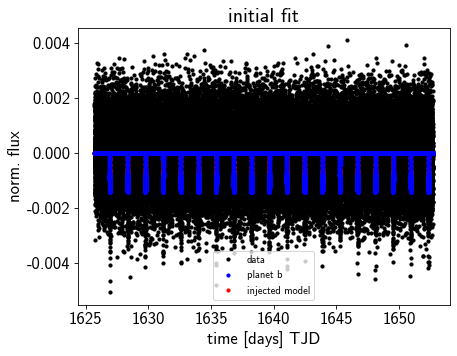

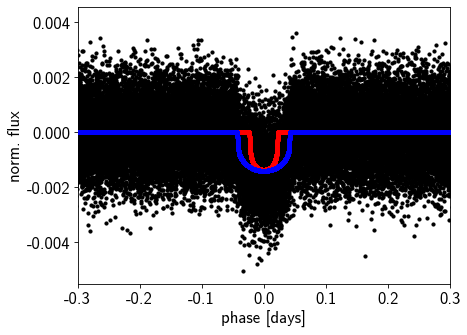

starting sampling chains



Sampling 2 chains: 100%|██████████| 1004/1004 [04:08<00:00,  1.80draws/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rb, u, logP, t0, mean]
Sampling 2 chains: 100%|██████████| 2000/2000 [04:34<00:00,  5.47draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


runtime:  47.397223353385925  minutes



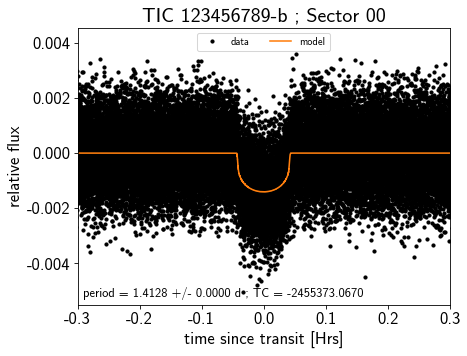

True Period:  1.4128919662158916
True time start:  1626.932307514362
True planet radius (RE):  1.5266796599398882
True Stellar radius (RS):  0.42344149694509003


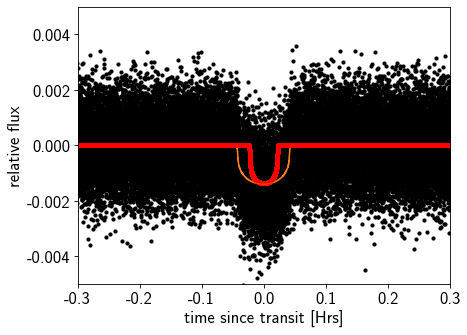

making posterior plots



/Users/felizd/anaconda2/envs/py3.6/lib/python3.7/site-packages/ipykernel_launcher.py:198: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


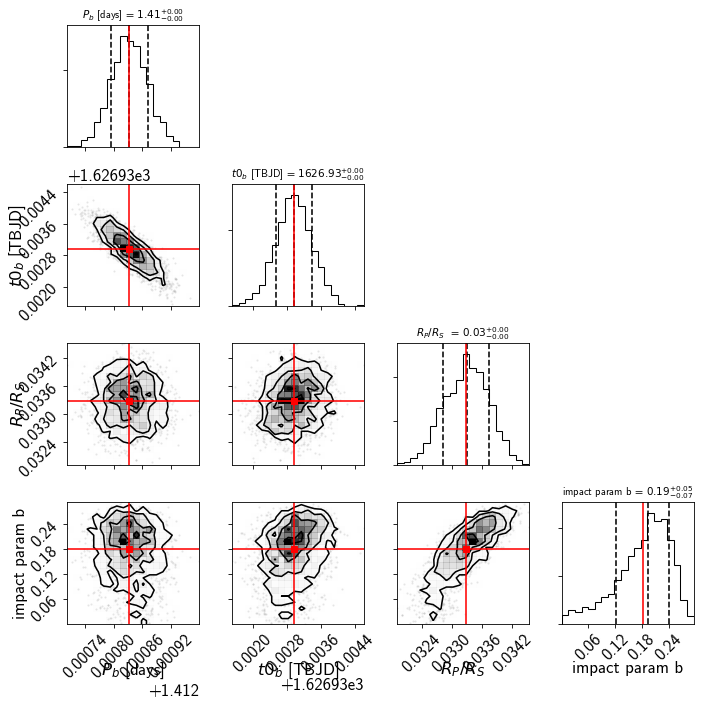

In [124]:
#Try it out

MCMCfigpath=os.getcwd()+'/MCMC_figures/'

model = MCMC_planet_model(ID, Sector, T,F,E, qld_a, qld_b, R_star, R_star_err,\
                  Periods, T0s, Depths, MCMCfigpath)